# Exercice polynômes orthogonaux : application au cas de la déviation verticale de la poutre encastrée

## References
* http://openturns.github.io/openturns/master/user_manual/_generated/openturns.HermiteFactory.html

# Problème

On considère une poutre encastrée de longueur $L$, section modulaire $I$ et modulus de Young $E$. Une des extrémités est fixe et on applique une charge ponctuelle $F$ à l'autre extrémité, ce qui provoque une déviation verticale $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\}$
* $E$ : Young modulus (Pa)
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4),
* $F$ : Loading (N)

|Variable|  Distribution|
| ------------- |-------------|
|E| Beta(alpha = 0.9, beta = 2.2, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L| Uniform(min=250.0, max= 260.0)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|

Les variables d'entrée sont supposées indépendantes.

## La classe HermiteFactory

In [1]:
import openturns as ot
import numpy as np
import scipy.special as scp

La classe `HermiteFactory` permet de créer des polynômes de Hermite orthonormés par rapport à la densité de probabilité gaussienne.

In [2]:
pofa = ot.HermiteFactory()

La méthode `build` créée un polynôme de degré donné.

In [3]:
for k in range(5):
    print(pofa.build(k))

1
X
-0.707107 + 0.707107 * X^2
-1.22474 * X + 0.408248 * X^3
0.612372 - 1.22474 * X^2 + 0.204124 * X^4


Concentrons-nous sur le polynôme de degré 5. 

In [4]:
pk = pofa.build(5)
pk

<openturns.orthogonalbasis.OrthogonalUniVariatePolynomial; proxy of <Swig Object of type 'OT::OrthogonalUniVariatePolynomial *' at 0x165bad6b0> >

In [5]:
pk.getDegree()

5

L'opérateur `()` permet d'évaluer le polynôme en un point.

In [6]:
pk(3.)

1.6431676725155

La méthode `getCoefficients` retourne une table des coefficients du polynôme. Le coefficient correspondant au monôme de plus haut degré est le dernier.

In [7]:
pk.getCoefficients()

class=Point name=Unnamed dimension=6 values=[0,1.36931,-0,-0.912871,0,0.0912871]

Comme chaque polynôme retourné est une fonction, la méthode `draw` permet de les dessiner.

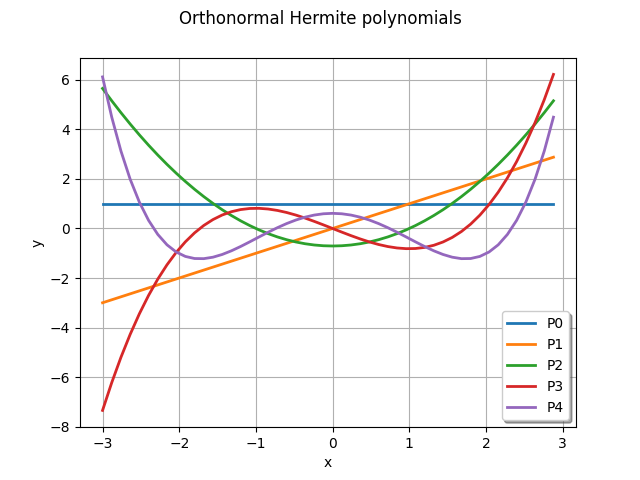

In [8]:
degreemax = 5
palette = ot.Drawable.BuildDefaultPalette(degreemax)
graph = ot.Graph("Orthonormal Hermite polynomials","x","y",True,"bottomright")
for k in range(degreemax):
    pk = pofa.build(k)
    curve = pk.draw(-3.,3.,50)
    curve.setLegends(["P%d" % (k)])
    graph.add(curve)
graph.setColors(palette) # Add colors
graph

## Les polynômes sont orthonormés pour la densité

Dans OpenTURNS, les polynômes sont orthonormés pour la densité de probabilité. Par conséquent, ils ne sont généralement pas moniques, c'est à dire que le coefficient associé au monôme de plus haut degré n'est pas toujours égal à 1.

In [9]:
def linearSample(xmin,xmax,npoints):
    '''Returns a sample created from a regular grid 
    from xmin to xmax with npoints points.'''
    step = (xmax-xmin)/(npoints-1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices

Dans la boucle `for` suivante, on considère les polynômes d'Hermite de degré 0 à 5. Pour chaque degré, on affiche le coefficient du monôme de plus grand exposant, son inverse ainsi que le facteur $\sqrt{k!}$. On observe que le coefficient du monôme de plus grand degré n'est pas toujours égal à 1. Pour obtenir des polynômes moniques, nous utilisons le facteur de normalisation. 

In [10]:
degreemax = 5
for k in range(degreemax):
    pk = pofa.build(k)
    leadingCoeff = pk.getCoefficients()[-1] # Coefficient for maximum exponent
    inverseLeadingCoeff = 1./leadingCoeff
    normalizationFactor = np.sqrt(scp.factorial(k))
    print("P%d, Leading coeff. = %f, Inverse = %f, Factor = %f" % (k,leadingCoeff,inverseLeadingCoeff,normalizationFactor))

P0, Leading coeff. = 1.000000, Inverse = 1.000000, Factor = 1.000000
P1, Leading coeff. = 1.000000, Inverse = 1.000000, Factor = 1.000000
P2, Leading coeff. = 0.707107, Inverse = 1.414214, Factor = 1.414214
P3, Leading coeff. = 0.408248, Inverse = 2.449490, Factor = 2.449490
P4, Leading coeff. = 0.204124, Inverse = 4.898979, Factor = 4.898979


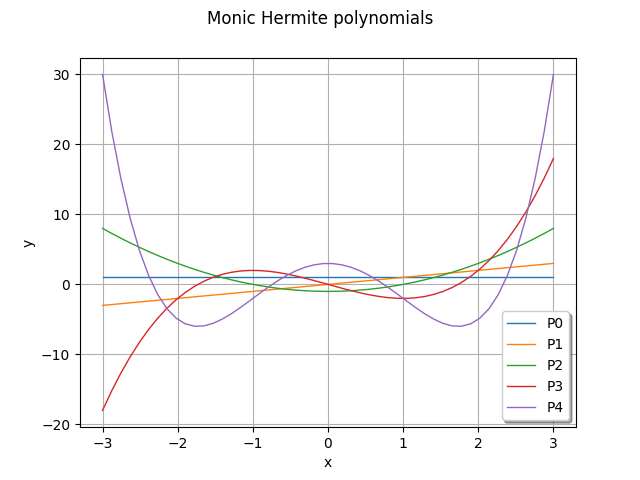

In [11]:
npoints = 50
x = linearSample(-3.,3.,npoints)
palette = ot.Drawable.BuildDefaultPalette(degreemax)
graph = ot.Graph("Monic Hermite polynomials","x","y",True,"bottomright")
for k in range(degreemax):
    pk = pofa.build(k)
    y = ot.Sample(npoints,1)
    for i in range(npoints):
        y[i,0] = pk(x[i,0])
    normalizationFactor = np.sqrt(scp.factorial(k))
    y = y*normalizationFactor
    curve = ot.Curve(x,y)
    curve.setLegend("P%d" % (k))
    graph.add(curve)
graph.setColors(palette) # Add colors
graph

## La récurrence à trois termes

La méthode `getRecurrenceCoefficients` permet d'obtenir les coefficients de la récurrence à trois termes permettant d'évaluer les polynômes:
$$
P_{n+1}(x) = (a_{0,n} x + a_{1,n}) P_n(x) + a_{2,n} P_{n-1}(x)
$$
pour $n\neq 0$ et tout $x\in\mathbb{R}$. En d'autres termes, la méthode `getRecurrenceCoefficients(n)` retourne les coefficients $(a_{0,n},a_{1,n},a_{2,n})$ permettant de calculer $P_{n+1}$ en fonction de $P_n$ et $P_{n-1}$. 

In [12]:
for n in range(5):
    print(pofa.getRecurrenceCoefficients(n))

[1,0,0]
[0.707107,0,-0.707107]
[0.57735,0,-0.816497]
[0.5,0,-0.866025]
[0.447214,0,-0.894427]


## Définir des polynômes univariés de manière automatique

Dans cette partie, on montre comment définir des polynômes univariés dans le cas de la poutre encastrée. Nous voyons comment créer la famille de polynômes orthogonaux associé à une variable aléatoire. Nous analysons la mesure associée à une famille de polynômes orthogonaux et montrons comment dessiner les polynômes.

Pour commencer, on définit une variable aléatoire de loi uniforme.

In [13]:
dist_L = ot.Uniform(250., 260.) # in cm

Puis on créée le polynôme univarié associé à cette variable avec la classe `StandardPolynomialFactory`.

In [14]:
factory_L = ot.StandardDistributionPolynomialFactory(dist_L)
factory_L

class=StandardDistributionPolynomialFactory hasSpecificFamily=true specificFamily=class=OrthogonalUniVariatePolynomialFamily implementation=class=LegendreFactory measure=class=Uniform name=Uniform dimension=1 a=-1 b=1

On observe que les polynômes orthogonaux associés à la loi uniforme sont les polynômes de Legendre.

Pour générer le polynôme de degré zéro associée à cette famille, on utilise la méthode `build`.

In [15]:
P0 = factory_L.build(0)
P0

<openturns.orthogonalbasis.OrthogonalUniVariatePolynomial; proxy of <Swig Object of type 'OT::OrthogonalUniVariatePolynomial *' at 0x17fc27ed0> >

Pour toute famille de polynômes orthogonaux, le polynôme de degré zéro est toujours égal à 1. Observons les polynômes de degrés 0 à 5 :

In [16]:
for i in range(5):
    Pi = factory_L.build(i)
    print(Pi)

1
1.73205 * X
-1.11803 + 3.3541 * X^2
-3.96863 * X + 6.61438 * X^3
1.125 - 11.25 * X^2 + 13.125 * X^4


Pour toute famille de polynômes orthogonaux, on *standardise* la densité de probabilité pour obtenir une famille dont les paramètres sont constants : dans OpenTURNS, on nomme cette distribution la *mesure*. La méthode `getMeasure` permet de l'obtenir :

In [17]:
measure = factory_L.getMeasure()
measure

class=Uniform name=Uniform dimension=1 a=-1 b=1

Comme cette distribution est uniforme, on peut facilement obtenir les bornes associées avec la methode `getRange`. 

In [18]:
Lrange = measure.getRange()
Lmin = Lrange.getLowerBound()[0]
Lmax = Lrange.getUpperBound()[0]
print(Lmin)
print(Lmax)

-1.0
1.0


On souhaite ensuite dessiner le polynôme orthogonal de degré 6 : on utilise la méthode `draw`.

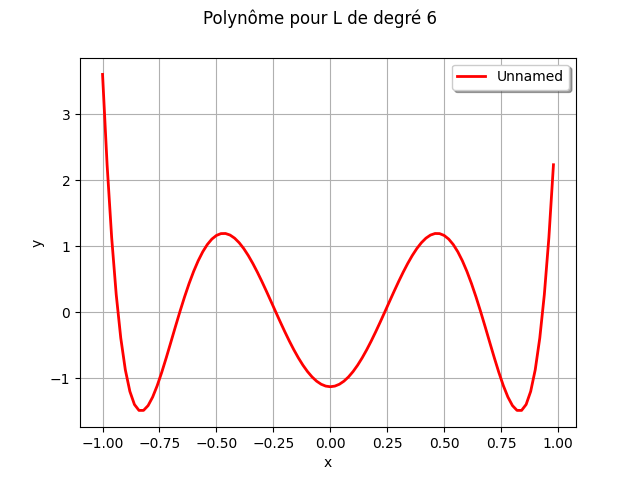

In [19]:
P6 = factory_L.build(6)
graph = P6.draw(Lmin,Lmax,100)
graph.setTitle("Polynôme pour L de degré 6")
graph

## Exercice 1 : vérifier la récurrence à trois termes pour les polynômes d'Hermite

L'objectif de cet exercice est de vérifier la récurrence à trois termes en utilisant la formule de récurrence.

La fonction `evalPolynomialFactory` suivante utilise la formule de récurrence à trois termes pour évaluer les polynômes d'Hermite. 
- Dans une boucle `for`, elle appele la méthode `getRecurrenceCoefficients` pour obtenir les coefficients de la récurrence $(a_{0,n},a_{1,n},a_{2,n})$. 
- Puis elle utilise la formule de récurrence pour calculer $P_{n+1}$ en fonction de $P_n$ et $P_{n-1}$. 

In [20]:
def evalPolynomialFactory(x,polyfact,degree):
    '''Evaluates the orthogonal polynomial with given degree 
    at point x using the recurrence :    
    Pn+1(x) = (a0n * x + a1n) * Pn(x) + a2n * Pn-1(x)
    of the polynomial factory polyfact.'''
    if (degree==0):
        p = 1.
    else:
        pp = 0. # Previous : Pn-1
        pc = 1. # Current : Pn
        for n in range(0,degree):
            # Evalue Pn+1(x) en fonction de Pn et Pn-1
            a0, a1, a2 = polyfact.getRecurrenceCoefficients(n)
            p = (a0 * x + a1)*pc + a2*pp
            pp = pc
            pc = p
    return p

Valider la fonction `evalPolynomialFactory` en comparant ses sorties avec celles du polynôme.

- En utilisant la fonction `linearSample`, créer la variable `x` contenant une liste de `npoints=5` abscisses régulièrement réparties entre -3 et 3. 


- Puis, réaliser une boucle `for` sur les degrés $k$ de 0 à 5. 


- Pour chaque degré `k`, créer le polynôme `pk` de degré `k`, puis réaliser une boucle sur les indices `i` des abscisses.


- Pour chaque abscisse, évaluer le polynôme `pk` avec son opérateur `()` et comparer avec la valeur de la fonction `evalPolynomialFactory`.

Pour vous aider, vous pouvez vous inspirer du squelette suivant, dans lequel vous remplacerez les sections *TODO* par du code Python valide.

```
npoints = 5
x = linearSample(-3.,3.,npoints)
for k in range(5):
    print("Degree = %d" % (k))
    pk = pofa.build(TODO)
    for i in range(npoints):
        y = evalPolynomialFactory(TODO)
        ytrue = TODO
        print("x=%f, y=%f, True y = %f" % (x[i,0],y,ytrue))
```

## Exercice 2 : vérification de l'orthornormalité des polynômes

L'objectif de cet exercice est d'observer l'orthonormalité des polynômes par rapport à la densité de probabilité associée. 

L'objectif est de vérifier que le produit scalaire satisfait l'égalité :
$$
\int_\mathbb{R} P_j(x) P_k(x) f(x) dx = \delta_{jk}
$$
pour $j,k= 0,...,5$.

Pour cela, nous définissons la fonction `integrandPiJPiKF` qui évalue la fonction $P_j(x) P_k(x) f(x)$ pour tout $x\in\mathbb{R}$.

In [21]:
def integrandPiJPiKF(x):
    '''Evaluates pj(x) * pk(x) * f(x) where 
    x is a dimension 1 Point, 
    hermitePolynomialJ is the degree-j polynomial from the Hermite polynomial factory,
    hermitePolynomialK is the degree-k polynomial from the Hermite polynomial factory,
    gaussianRandomVariable is a Normal() distribution, 
    f is the PDF of the distribution.
    '''
    f = gaussianRandomVariable.computePDF(x)
    yf = hermitePolynomialJ(x[0]) * hermitePolynomialK(x[0]) * f
    return [yf]

gaussianRandomVariable = ot.Normal()
integrandPiJPiKFPy = ot.PythonFunction(1,1,integrandPiJPiKF)

Pour évaluer l'intégrale, nous proposons d'utiliser la règle de Gauss-Kronrod implémentée dans la classe `GaussKronrodRule`. 

In [22]:
gkr = ot.GaussKronrodRule(ot.GaussKronrodRule.G11K23)
algo = ot.GaussKronrod(1000, 1e-16, gkr)

Il est nécessaire de fixer des bornes finies pour évaluer l'intégrale. Nous savons que la densité de probabilité de la loi gaussienne centrée et réduite est numériquement égale à zéro en dehors de l'intervalle [-38,38].

In [23]:
for v in [-38.0,-37.0,37.0,38.0]:
    print(gaussianRandomVariable.computePDF(v))

0.0
2.1200065515246056e-298
2.1200065515246056e-298
0.0


C'est pour cette raison que nous fixons ainsi les bornes de l'intervalle d'intégration.

In [24]:
bounds = ot.Interval(-38., 38.)

Le produit scalaire peut alors être calculé avec les instructions :
```
hermitePolynomialJ = pofa.build(j)
hermitePolynomialK = pofa.build(k)
pscalJK = algo.integrate(integrandPiJPiKFPy, bounds)[0]
```

Réaliser une boucle sur les indices `j` et `k` entre 0 et 5 et évaluer le produit scalaire : qu'observez-vous ?

## Exercice 3 : orthonormalisation d'une densité de probabilité

La classe `AdaptiveStieltjesAlgorithm` propose un algorithme pour générer la base orthonormale associée à une densité de probabilité donnée. Sur le principe, cette classe réalise l'algorithme de Gram-Schmidt pour générer la base orthonormale à partir de la base canonique. L'implémentation repose en fait sur un algorithme plus précis sur le plan numérique, en particulier pour les polynômes de dégré élevés.

L'objectif de cet exercice est de comparer les polynômes obtenus par la classe `AdaptiveStieltjesAlgorithm` pour la loi uniforme avec les polynômes de Legendre.

* Dans un premier temps, on utilise l'algorithme d'orthonormalisation.
  * Créer la variable `measure` contenant une variable uniforme standard.

  * Utiliser la classe `AdaptiveStieltjesAlgorithm` pour créer un algorithme d'orthonormalisation `algo`.

  * Utiliser la classe `StandardDistributionPolynomialFactory` pour créer la variable `pofa` sur cet algorithme.

  * Utiliser la méthode `build` pour afficher les polynômes de degrés 0 à 4 correspondants.

* Dans un second temps, on utilise les polynômes de Legendre.
  * Utiliser la classe `LegendreFactory` pour créer la variable `lefa`.

  * Utiliser la variable `lefa` pour afficher les polynômes de Legendre de degrés 0 à 4 correspondants.

* Comparer les deux résultats : qu'observez-vous ?

## Exercice 4 : polynômes orthogonaux pour une variable gaussienne

* Créer la famille de polynômes orthogonaux associés à une variable $X$ de loi normale de moyenne 12 et d'écart-type 3.4 :
```
N = ot.Normal(12.,3.4)
```

* Quelle est la famille de polynômes orthogonaux associés à cette variable ?

* Afficher les polynômes de degrés 0 à 5 associés.

* Quelle est la mesure standard associée ?

* On souhaite dessiner le polynôme de degré 6 associé à cette mesure : pourquoi ne peut-on pas utiliser la méthode `getRange` pour déterminer les bornes ? 

* Utiliser la méthode `computeBilateralConfidenceInterval` pour déterminer l'intervalle de confiance à 95% : en déduire des bornes pour dessiner le polynôme.

* Dessiner le polynôme de degré 6 associé à cette mesure.

## Exercice 5 : polynômes orthogonaux pour la variable F

* Créer la famille de polynômes orthogonaux associés à la variable $F$ :
```
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
```

* Quelle est la famille de polynômes orthogonaux associés à cette variable ?

* Afficher les polynômes de degrés 0 à 5 associés.

* Quelle est la mesure standard associée ?

* On souhaite dessiner le polynôme de degré 6 associé à cette mesure : pourquoi ne peut-on pas utiliser la méthode `getRange` pour déterminer les bornes ? 

* Utiliser la méthode `computeBilateralConfidenceInterval` pour déterminer l'intervalle de confiance à 95% : en déduire des bornes pour dessiner le polynôme.

* Dessiner le polynôme de degré 6 associé à cette mesure.